# Simulating your own quantum device
Author: Boxi Li (etamin1201@gmail.com)

The noisy device simulator of QuTiP performs simulation of quantum circuit at the level of open system time evolution (see [Noisy quantum device simulation with QuTiP](qip-noisy-device-simulator.ipynb) for details). In this notebook, we show how to define customized quantum system under this framework. The notebook is divided into three parts:
1. Customize the Hamiltonian model
2. Customize the compiler
3. Customize the noise

## Customize the Hamiltonian model

We start from the customization of the Hamiltonian model of the quantum system. It is represented by the class `Processor`. To simulate a customized quantum device, we will build it as a subclass of `ModelProcessor`, which is used for simulators based on concrete physics model (in contrast to optimal control). In this way, it inherits the necessary methods used in the simulation. A subclass can be built in three steps:
- compute the hardware parameters
- generate the available control Hamiltonian
- provide a compiler

In the next ceil, we show the definition of a customized `Processor` class as a whole block. In the ceils following, we will then have a closer look at each part of it one by one.


In [1]:
import numpy as np
from qutip import sigmax, sigmay, sigmaz, tensor, fidelity
from qutip.qip.pulse import Pulse
from qutip.qip.device import ModelProcessor

class MyProcessor(ModelProcessor):
    def __init__(self, num_qubits, h_x, h_z, g, t1=None, t2=None):
        super(MyProcessor, self).__init__(num_qubits, t1=t1, t2=t2)  # no decay for now
        self.pulse_mode = "discrete"  # The control pulse is discrete or continous.
        self.set_up_params(num_qubits, h_x, h_z, g)  # precompute the parameters
        self.set_up_ops(num_qubits)  # set up the available Hamiltonians
        self.dims = [2] * num_qubits  # The dimension of each controllable quantum system, here num_qubits qubits.
        self.num_qubits = num_qubits

    def set_up_params(self, num_qubits, h_x, h_z, g):
        self.params = {}
        self.params["sz"] = [2 * np.pi * h_z] * num_qubits  # for each qubtis, they can also be different
        self.params["sx"] = [2 * np.pi * h_x] * num_qubits
        self.params["g"] = [2 * np.pi * g] * num_qubits
        # Here goes all computation of hardware parameters. They all need to be saved in self.params for later use.
        # The computed parameters can be used e.g. in setting up the Hamiltonians or the compiler to compute the pulse coefficients.

    def set_up_ops(self, num_qubits):
        self.pulse_dict = {}  # A dictionary that maps the name of a pulse to its index in the pulse list.
        index = 0
        # sx_ops
        for m in range(num_qubits):
            self.add_control(sigmax(), m, label="sx" + str(m)) # sigmax pulse on m-th qubit with the corresponding pulse 
            self.pulse_dict["sx" + str(m)] = index
            index += 1
        # sz_ops
        for m in range(num_qubits):
            self.add_control(sigmaz(), m, label="sz" + str(m))
            self.pulse_dict["sz" + str(m)] = index
            index += 1
        # sxsy_ops
        operator = tensor([sigmax(), sigmax()]) + tensor([sigmay(), sigmay()])
        for m in range(num_qubits - 1):
            self.add_control(operator, [m, m+1], label="g" + str(m))
            self.pulse_dict["g" + str(m)] = index
            index += 1

    def load_circuit(self, circuit, schedule_mode=False, compiler=None):
        # compile the circuit to control pulses
        if compiler is None:
            from qutip.qip.compiler import SpinChainCompiler
            circuit = circuit.resolve_gates(basis=["ISWAP", "RX", "RZ"])
            # other supported gates includes RY, Cnum_qubitsOT, SQRTISWAP
            compiler = SpinChainCompiler(
                self.num_qubits, self.params, setup="linear", global_phase=0., pulse_dict=self.pulse_dict)
        tlist, coeffs = compiler.compile(circuit, schedule_mode=schedule_mode)
        # save the time sequence and amplitude for all pulses
        self.set_all_tlist(tlist)
        self.coeffs = coeffs
        return tlist, self.coeffs


This is a quantum system of $n$ qubits arranged in a chain, where we have control over three Hamiltonian: $\sigma_x$, $\sigma_z$ on each qubit, and neighbouring-qubits interaction $\sigma_x\sigma_x+\sigma_y\sigma_y$:

$$
H = \sum_{j=0}^{n-1} c_{1,j}(t) \cdot h_x^{j}\sigma_x^{j} + \sum_{j=0}^{n-1} c_{2,j}(t) \cdot h_z^{j}\sigma_z^{j}
+ \sum_{j=0}^{n-2} c_{3,j}(t)\cdot g^{j}(\sigma_x^{j}\sigma_x^{j+1}+\sigma_y^{j}\sigma_y^{j+1})
$$

where $h_x$, $h_z$, $g$ are the hardware parameters and $c_{i,j}(t)$ are the time-dependent control pulse coefficients. This Hamiltonian is the same as the one for the linear spin chain model in QuTiP. In general, the hardware parameters will not be identical for each qubit, but here, for simplicity, we represent them by three numbers: $h_x$, $h_z$ and $g$.

We can initialize the processor class with these parameters:

In [2]:
num_qubits = 2
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1)

In the following, we go through the three methods of this class.

### The hardware parameters:
In the `set_up_params` method, one can perform precomputation of hardware parameters, such as computing the coupling strength from the detuning. They will be saved in an attribute called `params`. If parameters are different for each qubits, it can be given as a Python list. Here, for demonstration, we only multiply each parameter with $2\pi$. The attribute `params` will be used in the compiler.

In [3]:
def set_up_params(self, num_qubits, h_x, h_z, g):
    self.params = {}
    self.params["sz"] = [2 * np.pi * h_z] * num_qubits  # for each qubtis, they can also be different
    self.params["sx"] = [2 * np.pi * h_x] * num_qubits
    self.params["g"] = [2 * np.pi * g] * num_qubits

`self.params` will be passed later to the compiler and used there.

### The available control Hamiltonian
In `set_up_ops`, we define the Hamiltonian of the quantum system and use them to initialize the control pulses.

In [4]:
def set_up_ops(self, num_qubits):
    self.pulse_dict = {}  # A dictionary that maps the name of a pulse to its index in the pulse list.
    index = 0
    # sx_ops
    for m in range(num_qubits):
        self.add_control(sigmax(), m, label="sx" + str(m)) # sigmax pulse on m-th qubit with the corresponding pulse 
        self.pulse_dict["sx" + str(m)] = index
        index += 1
    # sz_ops
    for m in range(num_qubits):
        self.add_control(sigmaz(), m, label="sz" + str(m))
        self.pulse_dict["sz" + str(m)] = index
        index += 1
    # sxsy_ops
    operator = tensor([sigmax(), sigmax()]) + tensor([sigmay(), sigmay()])
    for m in range(num_qubits - 1):
        self.add_control(operator, [m, m+1], label="g" + str(m))
        self.pulse_dict["g" + str(m)] = index
        index += 1

In the method above, we also save a dictionary `pulse_dict` between the name and index of each pulse:

In [5]:
processor.pulse_dict

{'sx0': 0, 'sx1': 1, 'sz0': 2, 'sz1': 3, 'g0': 4}

It can be used to identify the control pulse more conveniently:

In [6]:
sx0_pulse = processor.find_pulse("sx0")
sx0_pulse.print_info()

----------------------------------------------------------------------
Pulse label: sx0
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]], 'targets': [0], 'tlist': None, 'coeff': None}
----------------------------------------------------------------------


### Load and compile the circuit
To convert a quantum circuit into the Hamiltonian model, we need a compiler. The customized definition of a compiler will be discussed in details in the next section. Because we used the Hamiltonian model of the spin chain, we here simply "borrow" the compiler of the spin chain model.

To specify this compiler in the processor, we define a function `load_circuit`. It decomposes quantum gates into gates in the natural gates set of the corresponding hardware, compiles them to control pulses and stores the compiled pulse information.

In [7]:
def load_circuit(self, circuit, schedule_mode=False, compiler=None):
    # compile the circuit to control pulses
    if compiler is None:
        from qutip.qip.compiler import SpinChainCompiler
        circuit = circuit.resolve_gates(basis=["ISWAP", "RX", "RZ"])
        # other supported gates includes RY, Cnum_qubitsOT, SQRTISWAP
        compiler = SpinChainCompiler(
            self.num_qubits, self.params, setup="linear", pulse_dict=self.pulse_dict)
    tlist, coeffs = compiler.compile(circuit, schedule_mode=schedule_mode)
    # save the time sequence and amplitude for all pulses
    self.set_all_tlist(tlist)
    self.coeffs = coeffs
    return tlist, self.coeffs

### Run the simulation
With all these ingredients, we can now simulate quantum circuits on our customized processor. Here we use a two-qubit circuit with two X  gates. Acting on a $|00\rangle$ state, this results in a $|11\rangle$ state.

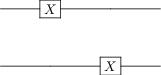

In [8]:
from qutip import basis
from qutip.qip.circuit import QubitCircuit
circuit = QubitCircuit(num_qubits)
circuit.add_gate("X", targets=1)
circuit.add_gate("X", targets=0)
circuit

For circuit plotting, see [this notebook](quantum-gates.ipynb).

In [9]:
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1)
processor.load_circuit(circuit)
result = processor.run_state(init_state = basis([2,2], [0,0]))
result.states[-1]

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 3.51162907e-13+0.00000000e+00j]
 [ 0.00000000e+00+8.07380330e-07j]
 [ 0.00000000e+00+4.16619521e-07j]
 [-1.00000000e+00+0.00000000e+00j]]

The compiled pulse coefficients are now saved in the processor and can be accessed by:

In [10]:
sx1_pulse = processor.find_pulse("sx1")
print(sx1_pulse.coeff)
print(sx1_pulse.tlist)

[6.28318531]
[0.   0.25]


This is a rectangle pulse that starts from time 0 and ends at time 0.25.

#### Note

Notice that， for discrete pulse, the time sequence is one element shorter than the pulse coefficient because we need to specify the start and the end of the pulse. If two sequences are of the same length, the last element of `coeff` will be neglected. Later, we will see continuous pulse where `coeff` and `tlist` have the same length.

To give an intuitive illustration of the control pulses, we give each pulse a latex label by defining a method `get_operators_labels` and then plot the compiled pulses.

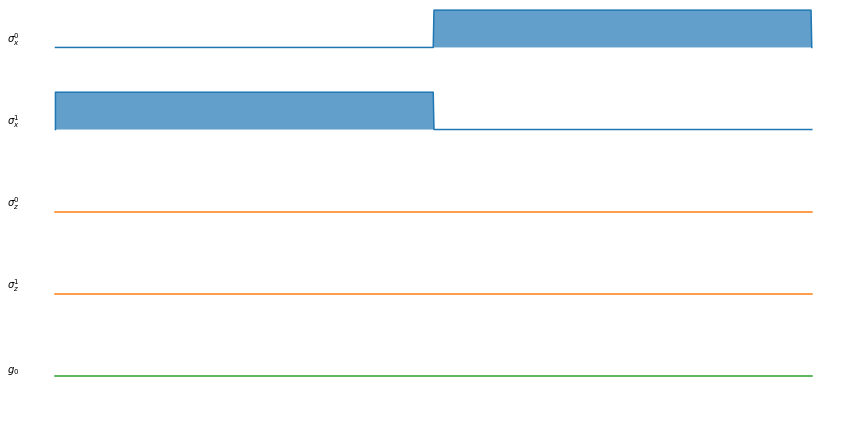

In [11]:
def get_operators_labels():
    """
    The function returns a 2-d nested list, in the plot,
    a different color will be used for each sublist.
    The total number of elements should match the number of control pulses.
    """
    return ([[r"$\sigma_x^%d$" % n for n in range(num_qubits)],
             [r"$\sigma_z^%d$" % n for n in range(num_qubits)],
             [r"$g_{%d}$" % (n) for n in range(num_qubits - 1)]])

processor.get_operators_labels = get_operators_labels
processor.plot_pulses();

## Customize the compiler

How the quantum gates are implemented on hardware varies on different quantum systems. Even on the same physical platform, different implementation will yield different performance. The simplest way of implementation is to define a rectangular pulse like the one above. However, in reality, the control signal will have a continuous shape. In the following, we show how to customize the compiler with a gaussian pulse.

A typical gate compiler function looks like the one in the following cell, with the form ``XX_compiler(self, gate, args)``. It takes two argument, `gate` and `args`: `gate` is the quantum gate to be compiled and `args` is a dictionary for additional parameters, for instance, parameters we defined in `Processor.set_up_params()`.

For each gate, the function returns the input gate, the time sequence and the pulse coefficients in an `Instruction` object.

Below is an example of a rectangular pulse.

In [12]:
from qutip.qip.compiler import Instruction
def rz_compiler(self, gate, args):
    """
    Compiler for the RZ gate
    """
    targets = gate.targets  # target qubit
    parameters = args["params"]  # get the params we defined in the processor
    h_x2pi = parameters["sx"][targets[0]]  #find the coupling strength for the target qubit
    coeff = np.sign(gate.arg_value) * h_x2pi  # compute the pulse coefficient, here just a constant
    tlist = abs(gate.arg_value) / (2 * h_x2pi)  # the oulse duration
    pulse_info = [("sx" + str(targets[0]), coeff)]  #  save the information in a tuple (pulse_name, coeff)
    # if you have more than one Hamiltonian to be turned on simultaneously, add it to the pulse_info list.
    # e.g. pulse_info = [(name_str1, coeff1), (name_str2, coeff2)]
    # They all have to follow the same time sequence given by tlist
    return [Instruction(gate, tlist, pulse_info)]
    # instruction is an object that includes the pulse coefficient and time sequence


Now we replace it with a Gaussian pulse. We define the Gaussian pulse in a way that the maximum matches the coupling strength $g$ and compute the $\sigma$ for the gaussian distribution from it. If you don't care about any parameters and just want to compile the gate to a fixed pulse sequence, you can also just define fixed `tlist` and `coeff` as two NumPy arrays.

In [13]:
def gauss_dist(t, sigma, amplitude, duration):
    return amplitude/np.sqrt(2*np.pi) /sigma*np.exp(-0.5*((t-duration/2)/sigma)**2)

def gauss_x_compiler(gate, args):
    """
    Compiler for the X gate
    """
    targets = gate.targets  # target qubit
    parameters = args["params"]
    h_x2pi = parameters["sx"][targets[0]]  # find the coupling strength for the target qubit
    amplitude = np.pi / 2. / 0.9973 #  0.9973 is just used to compensate the finite pulse duration so that the total area is fixed
    gate_sigma = h_x2pi / np.sqrt(2*np.pi)
    duration = 6 * gate_sigma
    tlist = np.linspace(0, duration, 100)
    coeff = gauss_dist(tlist, gate_sigma, amplitude, duration)
    pulse_info = [("sx" + str(targets[0]), coeff)]  #  save the information in a tuple (pulse_name, coeff)
    return [Instruction(gate, tlist, pulse_info)]

from qutip.qip.compiler import GateCompiler
class MyCompiler(GateCompiler):  # compiler class
    def __init__(self, num_qubits, params, pulse_dict):
        super(MyCompiler, self).__init__(
            num_qubits, params=params, pulse_dict=pulse_dict)
        # pass our compiler function as a compiler for RX (rotation around X) gate.
        self.gate_compiler["X"] = gauss_x_compiler
        self.args.update({"params": params})

The attribute `pulse_mode` can be set to `"discrete"` or `"continuous"`. For continuous pulse, QuTiP solvers will use cubic spline interpolation. To minimize the boundary effect, it is recommanded that the continuous pulse goes smoothly to 0 at the beginning and the end. We can see the advantage of the scheduling when we introduce a T1 decoherence and compare the fidelity of the final state.

In [14]:
gauss_compiler = MyCompiler(processor.num_qubits, processor.params, processor.pulse_dict)
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1, t1=300)
processor.pulse_mode = "continuous"
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler);
result = processor.run_state(init_state = basis([2,2], [0,0]))
print("fidelity without scheduling:", fidelity(result.states[-1], basis([2,2],[1,1])))

fidelity without scheduling: 0.9540068365944042


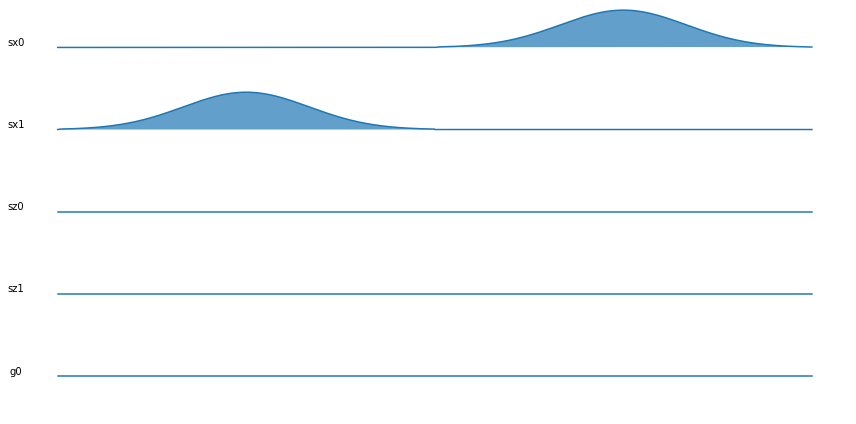

In [15]:
processor.plot_pulses();

We can also turn on the scheduler to schedule the circuit for run time duration.

In [16]:
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1, t1=300)
tlist, coeffs = processor.load_circuit(circuit, schedule_mode = "ASAP", compiler=gauss_compiler);
processor.pulse_mode = "continuous"
result = processor.run_state(init_state = basis([2,2], [0,0]))
print("fidelity with scheduling:", fidelity(result.states[-1], basis([2,2],[1,1])))

fidelity with scheduling: 0.978220241390956


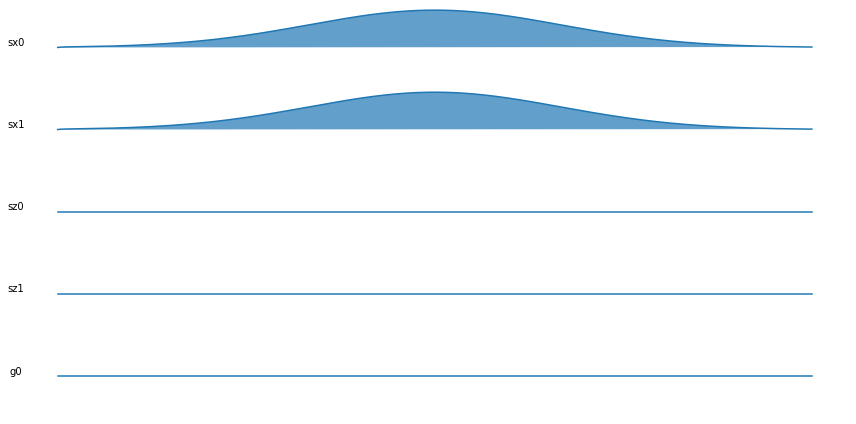

In [17]:
processor.plot_pulses();

### Define your own gate
The number of predefined gates in qutip is limited, hence you are encouraged to define your own gate. Here we show how to define a parametrized gate. First, you will need to define a gate function:

e:\boxi\onedrive\studium\qutip-project\qutip\qutip\qip\circuit.py:274: UserWarning: Unknown gate MYGATE
  warnings.warn("Unknown gate %s" % name)


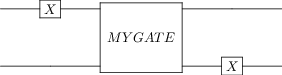

In [18]:
def mygate(theta = None):
    # We just call the Molmer Sorensen gate as an example.
    # If you do not want to run the circuit at the gate matrix level (circuit.run), no need for this function,
    # otherwise you will need to define this python function that returns the Qobj of the gate.)
    from qutip.qip.operations import molmer_sorensen
    return molmer_sorensen(theta, 2, targets=[0, 1])
circuit = QubitCircuit(2)
circuit.user_gates = {"MYGATE": mygate}  # no need for this if you don't use circuit.run
circuit.add_gate("X", targets=1)
circuit.add_gate("MYGATE", targets=[0,1], arg_value=3*np.pi/2)
circuit.add_gate("X", targets=0)
circuit
# You may see a warning because MYGATE is not found in defined LaTeX gate names, just ignore it.

In [19]:
circuit.run(basis([2,2],[0,0]))

Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.        -0.70710678j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.70710678+0.j        ]]

The next step is to define a compiler function for it. Since compiling a real MS gate is rather complicated, we here just use a dummy triangular pulse. The goal is to show how to get access to the parameter `theta` during the compiling.

In [20]:
def mygate_compiler(gate, args):
    targets = gate.targets  # target qubit
    parameters = args["params"]
    
    theta = gate.arg_value
    coeff1 = np.concatenate([np.linspace(0,5,50), np.linspace(5,0,50), [0]]) / 50
    coeff2 = np.concatenate([np.linspace(0,5,50), np.linspace(5,0,50), [0]]) / 50
    pulse_info = [("sx" + str(targets[0]), theta * coeff1),
                  ("sx" + str(targets[1]), theta * coeff2)
                 ]  #  save the information in a tuple (pulse_name, coeff)
    tlist = np.linspace(0, 10, len(coeff1))
    return [Instruction(gate, tlist, pulse_info)]

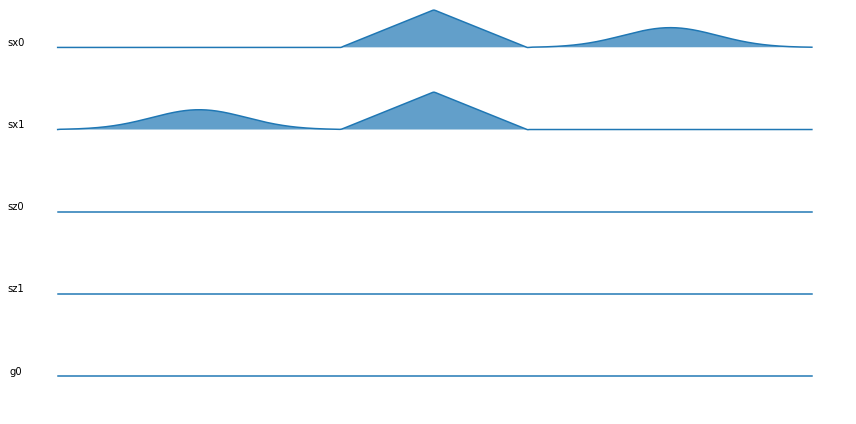

In [21]:
gauss_compiler = MyCompiler(processor.num_qubits, processor.params, processor.pulse_dict)
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1, t1=300)
gauss_compiler.gate_compiler["MYGATE"] = mygate_compiler
processor.pulse_mode = "continuous"
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler);
processor.plot_pulses();

## Customize noise
Apart from pre-defined noise such as T1, T2 noise and random noise in the control pulse amplitude (see this [notebook](qip-noisy-device-simulator.ipynb), one can also define customized noise. Here we will see two examples of customizing noise, one systematic (pulse-independent) noise and one pulse-dependent noise. 

To understand how noise is processed, we briefly introduced the data structure of the simulation framework. The control elements are stored as a list of `Pulse` objects in the Processor. In each Pulse contains the idea pulse, the control noise part and the decoherence part. For systematic noise, it is saved under the `Pulse` representation labelled `"system"`, which represents the intrinsic dynamics of the quantum system. For pulse-dependent noise, we will add them to their corresponding control `Pulse`. 

The definition of noise is realized by a subclass of `UserNoise`, including two methods: 
- the initialization method containing the property of the noise, such as frequency or amplitude.
- the method `get_noisy_dynamics` that takes all the control pulse `pulses`, a dummy `Pulse` object representing systematic noise and the dimension of the system (here two qubits `[2,2]`).


In [22]:
from qutip.qip.noise import Noise

class Extral_decay(Noise):
    def __init__(self, arg):
        self.arg = arg
        pass

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        pass

### Systematic noise

We first show an example of systematic noise. Here, we introduce a ZZ crosstalk noise between neighbouring qubits with a constant strength. It is done in three steps:

- Define the noise class.
- Initialize the noise object with given coupling strength.
- Define the Processor as usual and add the noise to the processor.

In the following example, we check the fidelity of the same circuit of two X gates, but now with this additional noise.

In [23]:
circuit = QubitCircuit(2)
circuit.add_gate("X", targets=1)
circuit.add_gate("X", targets=0)

In [24]:
from qutip import sigmaz
from qutip.qip.operations import expand_operator
from qutip.qip.pulse import Pulse
from qutip.qip.noise import Noise
class ZZ_crosstalk(Noise):
    def __init__(self, strength):
        self.strength = strength

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        zz_operator = tensor([sigmaz(), sigmaz()])
        for i in range(len(dims)-1):
            systematic_noise.add_control_noise(
                self.strength * zz_operator, targets=[i,i+1], tlist=None, coeff=True)  # constant, always 1

crosstalk_noise = ZZ_crosstalk(strength=0.05)

In [25]:
processor = MyProcessor(num_qubits=2, h_x=1.0, h_z=1.0, g=0.1)
processor.add_noise(crosstalk_noise)  # The noise is added to the processor
gauss_compiler = MyCompiler(processor.num_qubits, processor.params, processor.pulse_dict)
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler);

result = processor.run_state(init_state = basis([2,2], [0,0]))
print("Final fidelity with ZZ crosstalk:", fidelity(result.states[-1],basis([2,2],[1,1])))

Final fidelity with ZZ crosstalk: 0.9338019591934813


### Pulse dependent noise
In this second example, we demonstrate how to add an additional amplitude damping channel on the qubits. The amplitude of this decay is linearly dependent on the control pulse "sx", i.e. whenever the pulse "sx" is turned on, the decoherence is also turned on. The corresponding destroy operator has a coefficient proportional to the control pulse amplitude. This noise can be added on top of the default T1, T2 noise.

In [26]:
from qutip.qip.pulse import Pulse
class Extral_decay(Noise):
    def __init__(self, ratio):
        self.ratio = ratio

    def get_noisy_dynamics(self, dims, pulses, systematic_noise):
        from qutip import destroy
        op = destroy(2)
        for pulse in pulses:   # iterate for all pulses
            if "sx" in pulse.label and pulse.coeff is not None:   # if it is a sigma x pulse and is not empty
                pulse.add_lindblad_noise(op, targets=pulse.targets, tlist=pulse.tlist, coeff=self.ratio * pulse.coeff)
                # One can also use add_control_noise here to add addtional hamiltonian as noise (see next example).

extral_decay = Extral_decay(0.3)

In [27]:
processor = MyProcessor(num_qubits, h_x=1.0, h_z=1.0, g=0.1)
processor.add_noise(extral_decay)
gauss_compiler = MyCompiler(processor.num_qubits, processor.params, processor.pulse_dict)
tlist, coeff = processor.load_circuit(circuit, compiler=gauss_compiler);

result = processor.run_state(init_state = basis([2,2], [0,0]))
print("Final fidelity with pulse dependent decoherence:", fidelity(result.states[-1],basis([2,2],[1,1])))

Final fidelity with pulse dependent decoherence: 0.9914445928611332


In [1]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.6.0+c003ff5
Numpy,1.20.1
SciPy,1.5.3
matplotlib,3.3.0
Cython,0.29.21
Number of CPUs,12
BLAS Info,Generic
IPython,7.16.1
Python,"3.8.6 | packaged by conda-forge | (default, Oct 7 2020, 18:22:52) [MSC v.1916 64 bit (AMD64)]"
OS,nt [win32]
